In [ ]:
import numpy as np
import os
PATH = '/content/drive/MyDrive/Datasets/Skincolor'
print(os.listdir(PATH))
from os import walk
for (dirpath, dirnames, filenames) in walk(PATH):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from matplotlib.pyplot import figure

from torchvision import transforms, models
from tqdm import tqdm

['w99.jpg', 'b99.jpeg', 'train', 'test']
Directory path:  /content/drive/MyDrive/Datasets/Skincolor
Folder name:  ['train', 'test']
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/train
Folder name:  ['Afro', 'White']
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/train/Afro
Folder name:  []
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/train/White
Folder name:  []
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/test
Folder name:  ['Afro', 'White']
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/test/Afro
Folder name:  []
Directory path:  /content/drive/MyDrive/Datasets/Skincolor/test/White
Folder name:  []


### Трансформеры, Даталоадеры
Преобразование и аугментация выборки, создание даталоадеров для обучающей и тестовой выборки

In [ ]:
batch_size = 20
train_transforms = transforms.Compose([transforms.Resize((224, 224)), #(224, 224)
                                       #transforms.Grayscale(num_output_channels=1),
                                       transforms.RandomRotation(30),
                                       #transforms.TrivialAugmentWide(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], #[0.5, 0.5, 0.5]          
                                                            [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      #transforms.Grayscale(num_output_channels=1),
                                     #transforms.RandomRotation(30),
                                     #transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])

Создание тестовой выборки

In [ ]:
test_data = datasets.ImageFolder(PATH + '/test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=20)

In [ ]:
data_iter_test = iter(testloader)
x_test, y_test = next(data_iter_test)

Создание обучающей выборки заданной длины

In [ ]:
train_size = 100
train = []
for i in range(int(train_size / len(y_test))):
  train_temp = datasets.ImageFolder(PATH + '/train', transform=train_transforms)
  train = torch.utils.data.ConcatDataset([train, train_temp])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=train_size)

In [ ]:
data_iter_train = iter(trainloader)
x_train, y_train = next(data_iter_train)

Размеры моделей

In [ ]:
print('Обучающая выборка')
print(x_train.shape)
print(y_train.shape)

Обучающая выборка
torch.Size([100, 3, 224, 224])
torch.Size([100])


In [ ]:
print('Тестовая выборка')
print(x_test.shape)
print(y_test.shape)

Тестовая выборка
torch.Size([2, 3, 224, 224])
torch.Size([2])


### Показ примеров изображений

In [ ]:
x_train[i].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

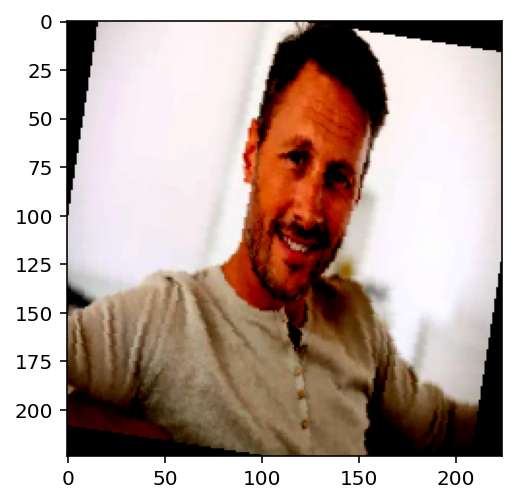

tensor(1)


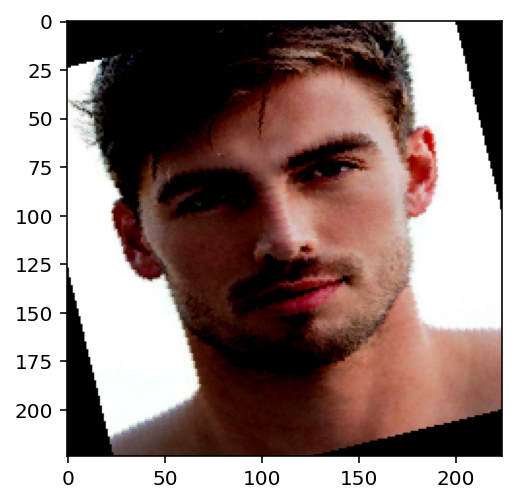

tensor(1)


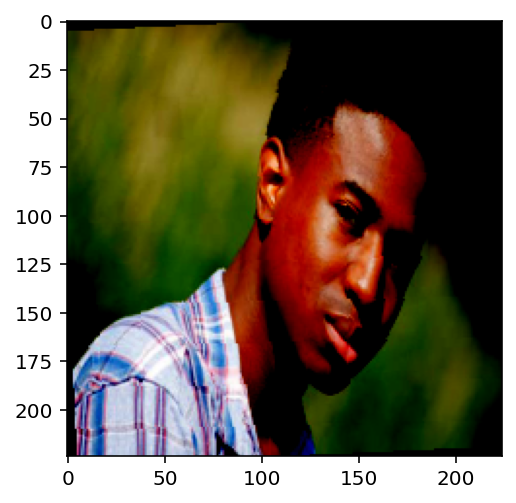

tensor(0)


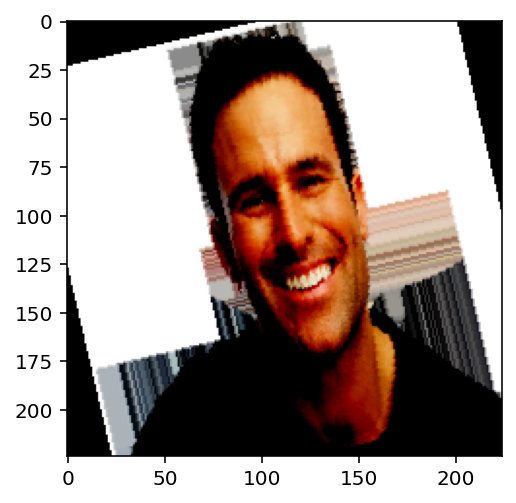

tensor(1)


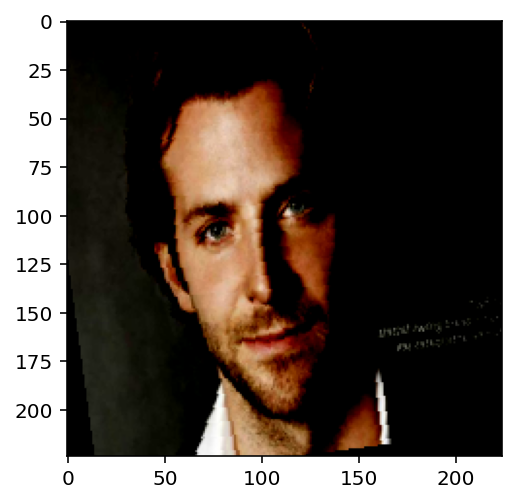

tensor(1)


In [ ]:
for i in range(0, len(x_train), 20):
  plt.imshow(x_train[i].permute(1, 2, 0).numpy())
  plt.show()
  print(y_train[i])

### Галерея изображений

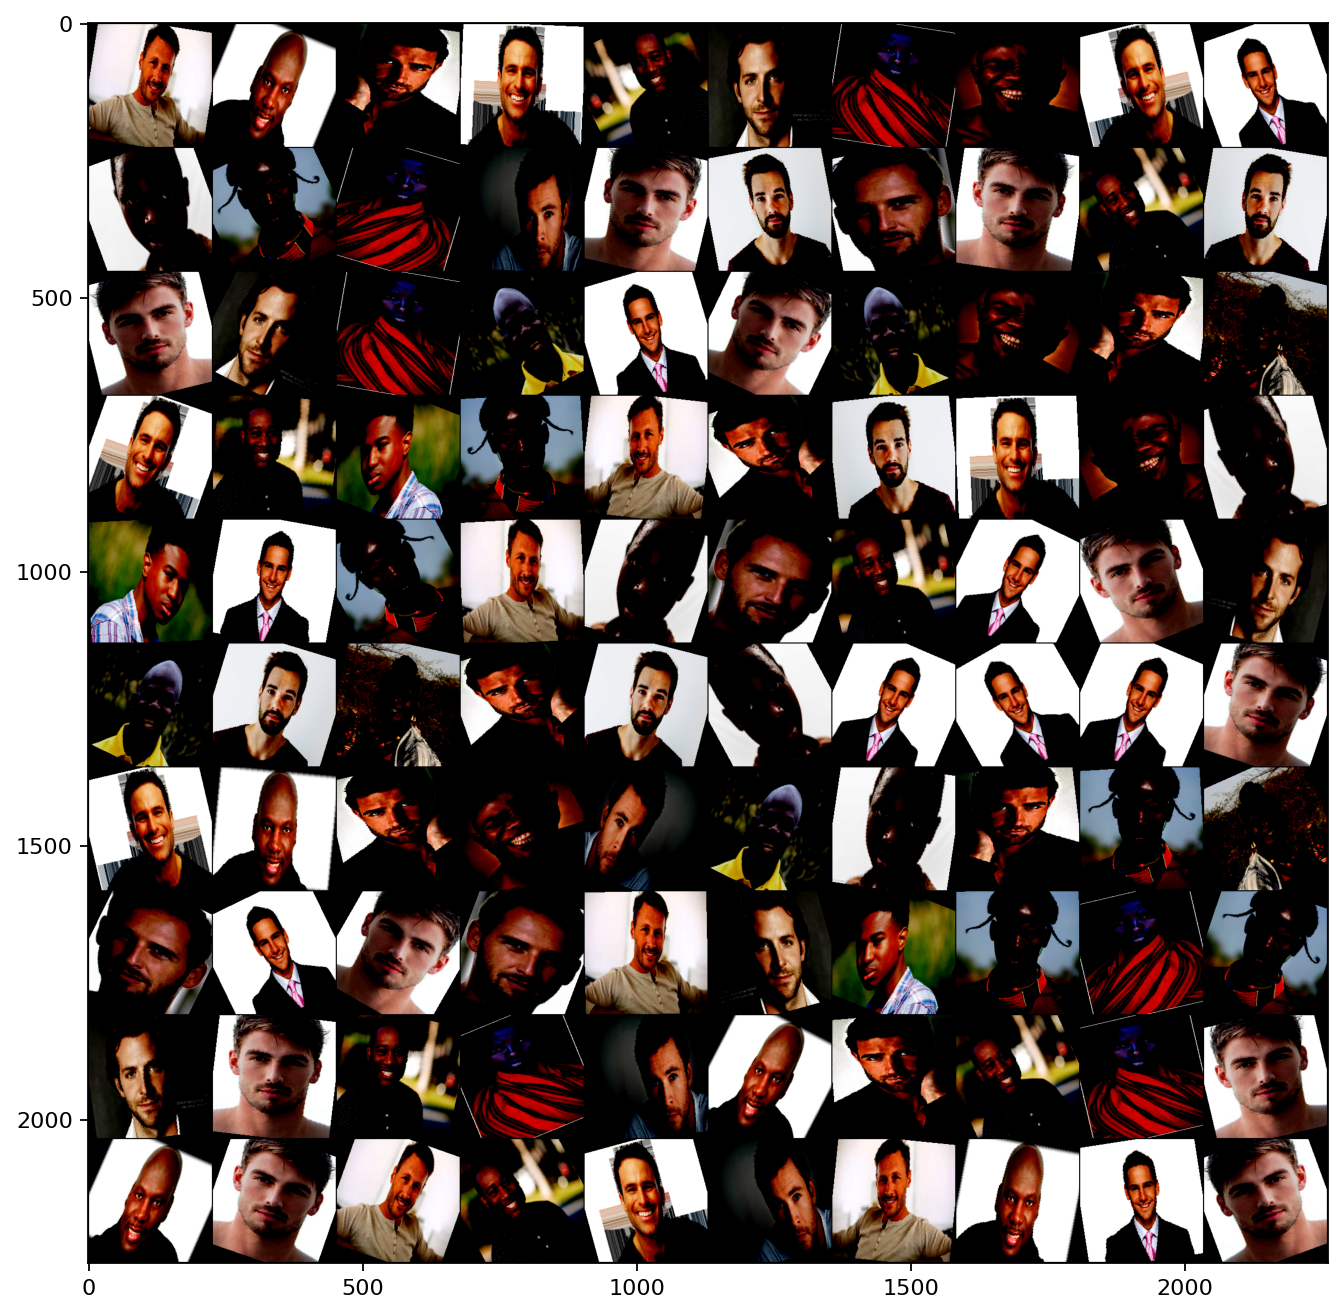

In [ ]:
grid = torchvision.utils.make_grid(x_train, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
grid.size()
figure(figsize=(10, 12), dpi=80)
plt.imshow(grid.permute(1, 2, 0))

### Создание обучающей модели

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # У каждой эпохи обучая и валидационная составляющая
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = trainloader
                scheduler.step()
                model.train()  # Перевод модели в режим обучения
            else:
                dataloader = testloader
                model.eval()   # Перевод модели в режим валидации

            running_loss = 0.
            running_acc = 0.

            # Перебор изображений и меток в датасете
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward и backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + оптимизация в стадии обучения
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # статистика
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            loss_values.append(epoch_loss)
            acc_values.append(epoch_acc.data.cpu())
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    plt.plot(np.array(loss_values), 'r', label='loss')
    plt.plot(np.array(acc_values), 'b', label='accuracy')
    plt.legend(loc='upper right')
    return model

### Обучение модели

In [ ]:
model = models.resnet18(pretrained=True)

# Отключения градиента для сверточных слоев
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Уменьшение LR by на значение 0.1 каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Проверка доступности графического ядра

In [ ]:
torch.cuda.is_available()

True

Epoch 0/32:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.5099 Acc: 0.7878



100%|██████████| 1/1 [00:00<00:00, 25.84it/s]

val Loss: 0.4193 Acc: 1.0000
Epoch 1/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.2652 Acc: 0.9711



100%|██████████| 1/1 [00:00<00:00, 32.69it/s]

val Loss: 0.4055 Acc: 1.0000
Epoch 2/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.1504 Acc: 0.9933



100%|██████████| 1/1 [00:00<00:00, 33.43it/s]

val Loss: 0.4619 Acc: 1.0000
Epoch 3/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.1149 Acc: 0.9967



100%|██████████| 1/1 [00:00<00:00, 31.38it/s]

val Loss: 0.4359 Acc: 1.0000
Epoch 4/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0759 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.02it/s]

val Loss: 0.4054 Acc: 1.0000
Epoch 5/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0592 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 32.22it/s]

val Loss: 0.3914 Acc: 1.0000
Epoch 6/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0525 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 34.09it/s]

val Loss: 0.3932 Acc: 1.0000
Epoch 7/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0508 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.17it/s]

val Loss: 0.3922 Acc: 1.0000
Epoch 8/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0547 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 34.05it/s]

val Loss: 0.3861 Acc: 1.0000
Epoch 9/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0505 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.24it/s]

val Loss: 0.3894 Acc: 1.0000
Epoch 10/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0464 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.46it/s]

val Loss: 0.3932 Acc: 1.0000
Epoch 11/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0460 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 32.73it/s]

val Loss: 0.3964 Acc: 1.0000
Epoch 12/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0454 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 26.53it/s]

val Loss: 0.3856 Acc: 1.0000
Epoch 13/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0454 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 35.17it/s]

val Loss: 0.3854 Acc: 1.0000
Epoch 14/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0459 Acc: 0.9989



100%|██████████| 1/1 [00:00<00:00, 33.00it/s]

val Loss: 0.3846 Acc: 1.0000
Epoch 15/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0476 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 35.74it/s]

val Loss: 0.3850 Acc: 1.0000
Epoch 16/32:



100%|██████████| 9/9 [00:14<00:00,  1.64s/it]

train Loss: 0.0442 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 32.35it/s]

val Loss: 0.3831 Acc: 1.0000
Epoch 17/32:



100%|██████████| 9/9 [00:14<00:00,  1.63s/it]

train Loss: 0.0495 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 36.01it/s]

val Loss: 0.3927 Acc: 1.0000
Epoch 18/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.0473 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 34.31it/s]

val Loss: 0.3889 Acc: 1.0000
Epoch 19/32:



100%|██████████| 9/9 [00:14<00:00,  1.62s/it]

train Loss: 0.0489 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 28.34it/s]

val Loss: 0.3903 Acc: 1.0000
Epoch 20/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.0441 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.34it/s]

val Loss: 0.3930 Acc: 1.0000
Epoch 21/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.0467 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 31.43it/s]

val Loss: 0.3853 Acc: 1.0000
Epoch 22/32:



100%|██████████| 9/9 [00:14<00:00,  1.59s/it]

train Loss: 0.0442 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.54it/s]

val Loss: 0.3900 Acc: 1.0000
Epoch 23/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0452 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.41it/s]

val Loss: 0.3826 Acc: 1.0000
Epoch 24/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0474 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 31.83it/s]

val Loss: 0.3896 Acc: 1.0000
Epoch 25/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.0457 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 32.22it/s]

val Loss: 0.3880 Acc: 1.0000
Epoch 26/32:



100%|██████████| 9/9 [00:14<00:00,  1.61s/it]

train Loss: 0.0509 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 34.40it/s]

val Loss: 0.3865 Acc: 1.0000
Epoch 27/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0494 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.08it/s]

val Loss: 0.3835 Acc: 1.0000
Epoch 28/32:



100%|██████████| 9/9 [00:14<00:00,  1.60s/it]

train Loss: 0.0436 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 29.32it/s]

val Loss: 0.3858 Acc: 1.0000
Epoch 29/32:



100%|██████████| 9/9 [00:14<00:00,  1.59s/it]

train Loss: 0.0448 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 34.30it/s]

val Loss: 0.3934 Acc: 1.0000
Epoch 30/32:



100%|██████████| 9/9 [00:14<00:00,  1.59s/it]

train Loss: 0.0448 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 32.22it/s]

val Loss: 0.3931 Acc: 1.0000
Epoch 31/32:



100%|██████████| 9/9 [00:14<00:00,  1.59s/it]

train Loss: 0.0467 Acc: 0.9989



100%|██████████| 1/1 [00:00<00:00, 33.91it/s]

val Loss: 0.3910 Acc: 1.0000
Epoch 32/32:



100%|██████████| 9/9 [00:14<00:00,  1.56s/it]

train Loss: 0.0445 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 33.43it/s]

val Loss: 0.3959 Acc: 1.0000


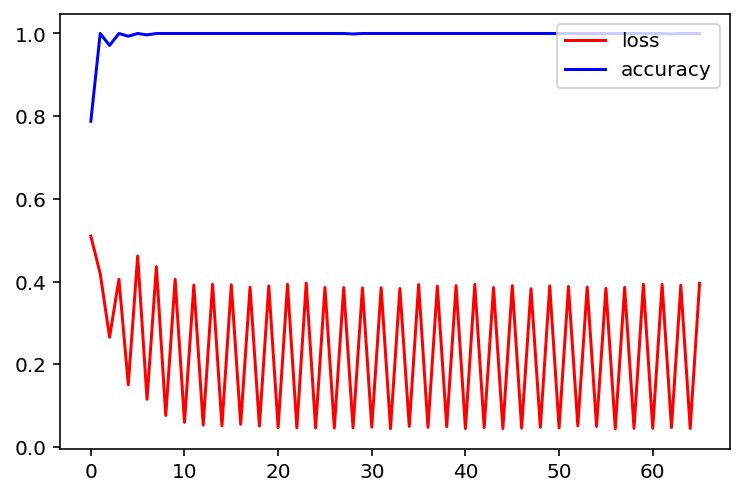

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=33);

Получение предсказаний

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []

x_test = x_test.to(device)
y_test = y_test.to(device)
with torch.set_grad_enabled(False):
  preds = model(x_test)
test_predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())

test_predictions = np.concatenate(test_predictions)

Получение предсказаний

0.41993475


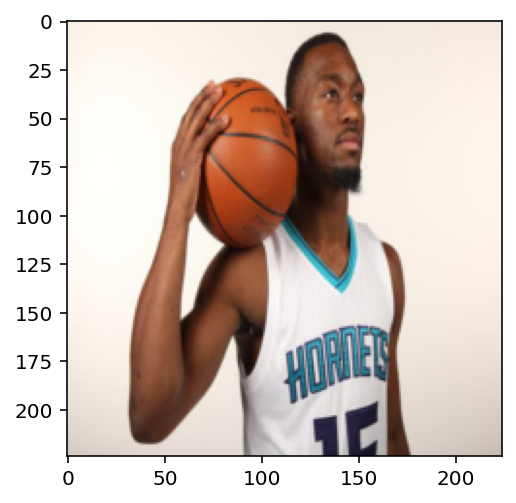

0.7810559


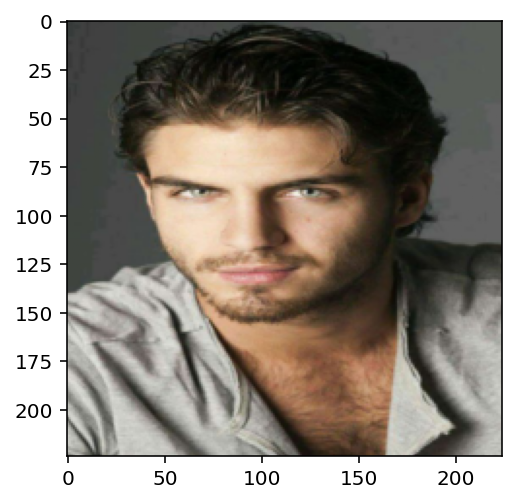

In [ ]:
inputs, labels = next(iter(testloader))

for img, pred in zip(inputs, test_predictions):
    plt.imshow(img.permute(1, 2, 0).numpy())
    print(pred)
    plt.show()

##Вывод

Как видим в условиях недостаточного количества изображений для обучения, модель на основе ResNet18 дает относительно близкие оценки классов (0 для темного цвета кожи и 1 для белого).  
При увеличении количества картинок для обучения результат будет улучшаться.